# Step 2: Calculation of some basic turbulence quantities
Based on the half-hourly output of the first notebook ([01_post-processing.ipynb](https://github.com/noctiluc3nt/ec_analyze/blob/main/notebooks/01_post-processing.ipynb)) some standard turbulence quantities, i.e. stability parameter, friction velocity, TKE, turbulence intensity are calculated and plotted.

In [11]:
#loading Reddy package
install.packages("../src/Reddy_0.0.0.9000.tar.gz",repos=NULL,source=TRUE)
library(Reddy)
library(latex2exp)
kap=function() return(0.4)

Installing package into ‘/home/lauracma/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



In [2]:
#read in processed example data
dat=readRDS("../data/ec-data_30min_processed/processed_data_example.rds")

### Calculation of standard turbulence diagnostics and simple timeseries plots
Here, some functions from the Reddy package are used to calculate turbulent kinetic energy $TKE$, velocity scale of TKE $V_{TKE}$, horizontal turbulence intensity $TI$, vertical turbulence intensity $I_w$, friction velocity $u_*$, Obukhov length $L$, stability parameter $\zeta$ and directional shear angle and plot their timeseries for the previously post-processed example data.

In [8]:
#calculation of some useful turbulence diagnostics
dat$tke=calc_tke(dat$u_sd,dat$v_sd,dat$w_sd)
dat$vtke=calc_vtke(dat$u_sd,dat$v_sd,dat$w_sd)
dat$ti=calc_ti(dat$u_sd,dat$v_sd,dat$ws_mean)
dat$iw=calc_iw(dat$w_sd,dat$ws_mean)
dat$ustar=calc_ustar(dat$cov_uw,dat$cov_vw)
dat$L=calc_L(dat$ustar,dat$T_mean,dat$cov_wT)
dat$zeta=calc_zeta(4.4,dat$L)
dat$alpha_uw=calc_dshear(dat$cov_uw,dat$cov_vw)

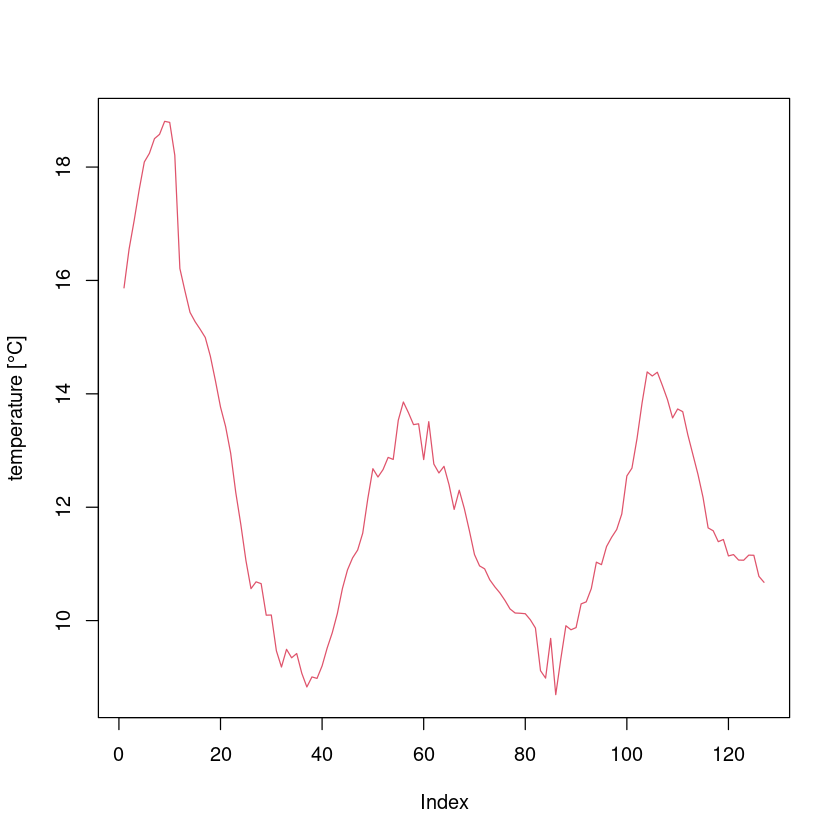

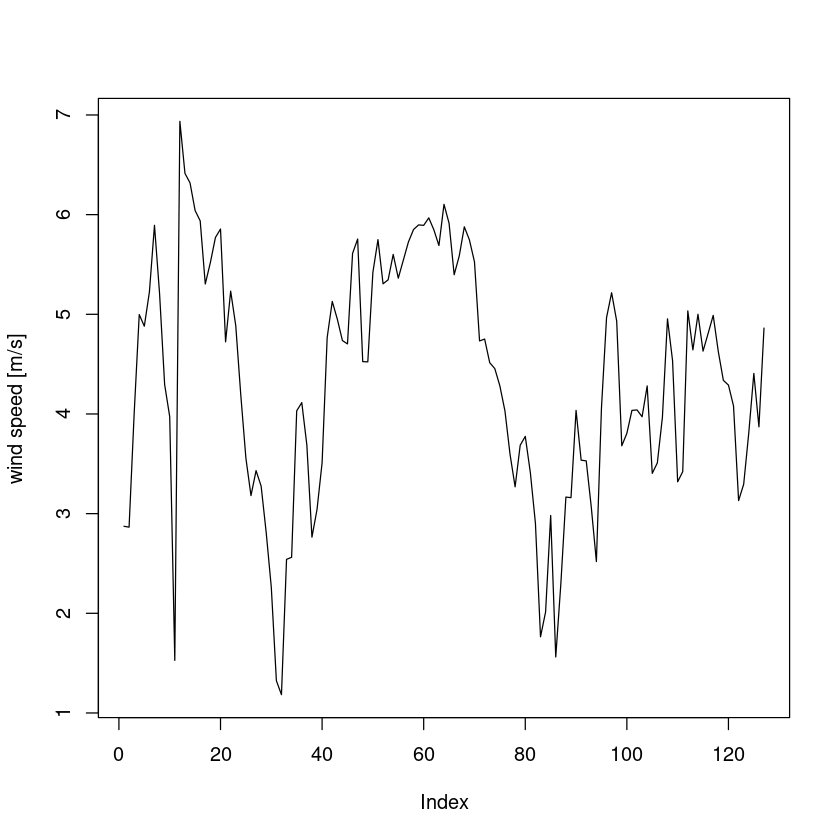

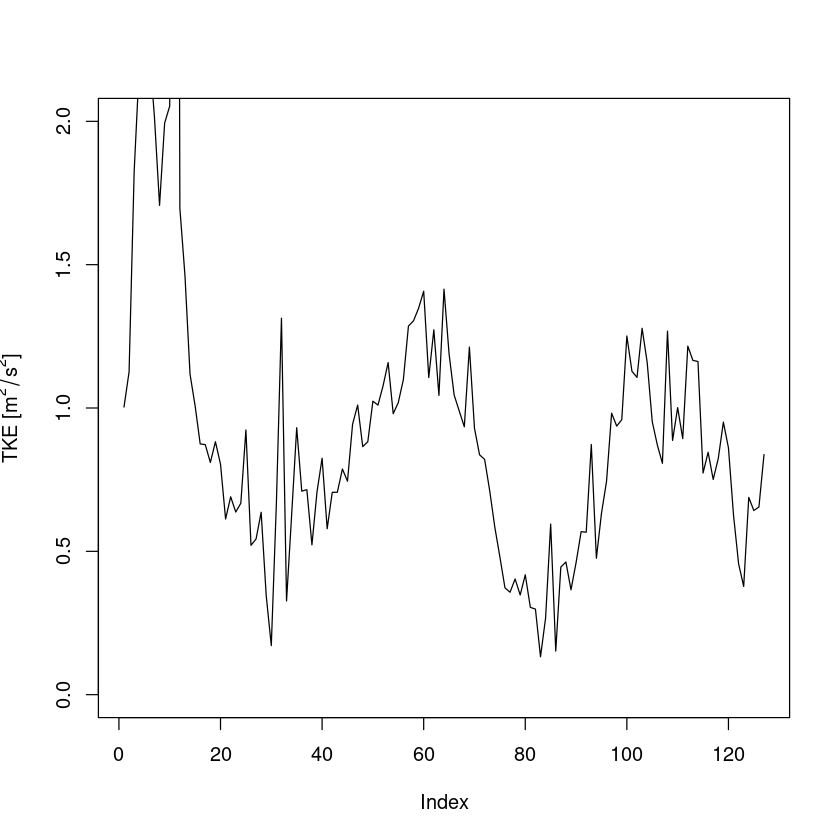

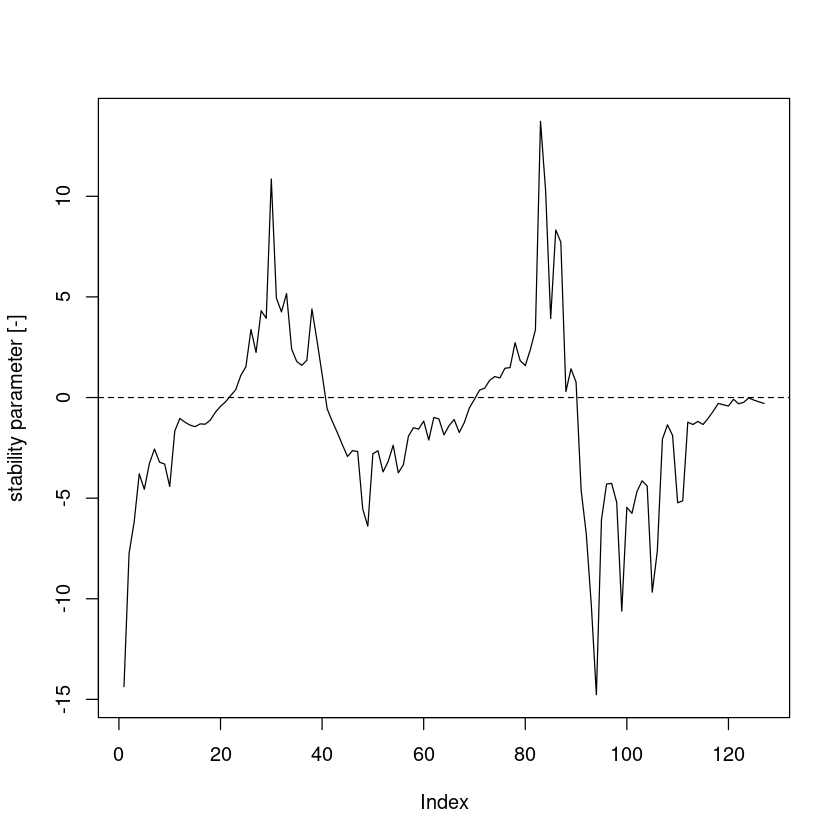

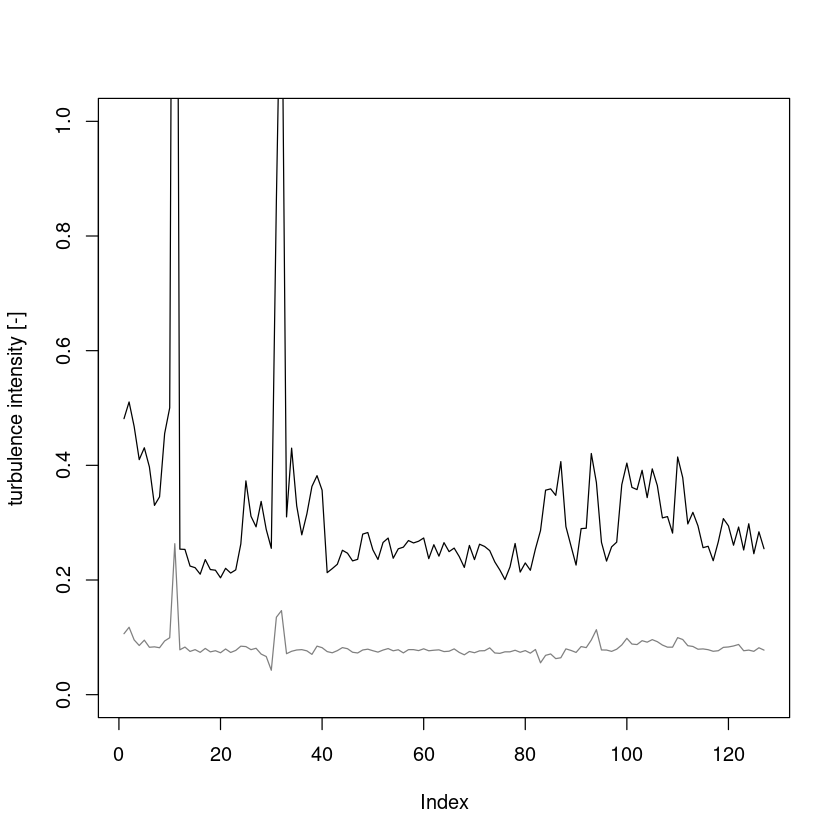

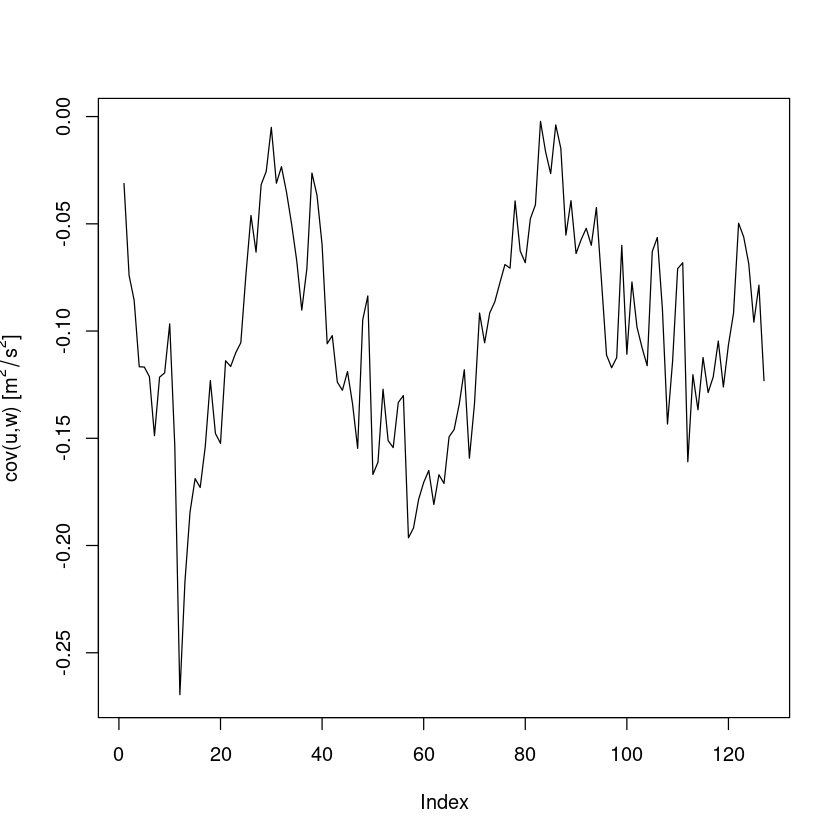

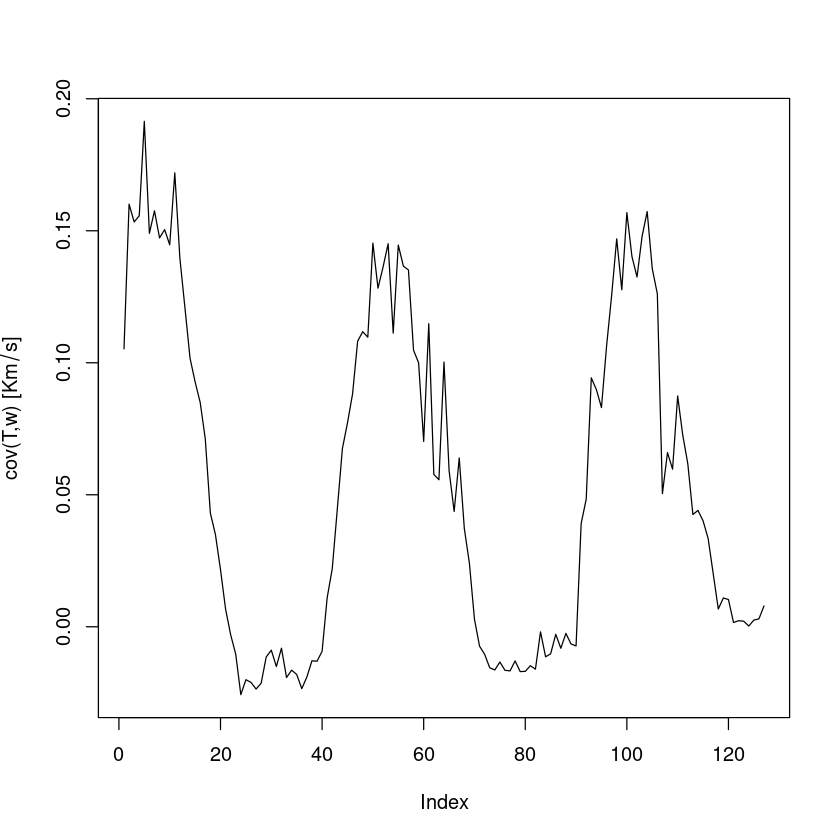

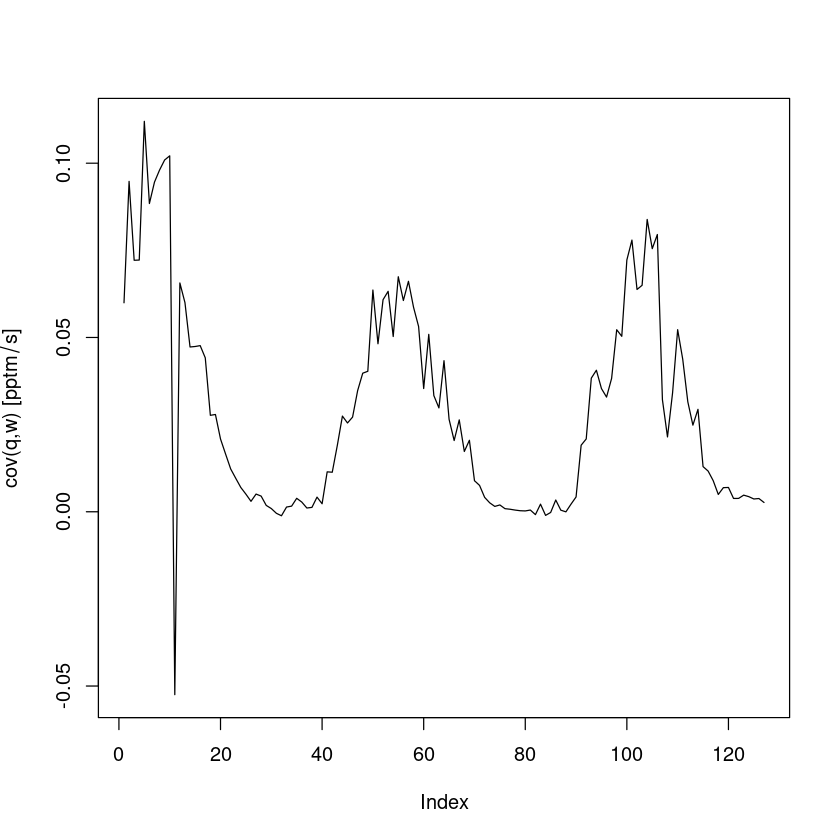

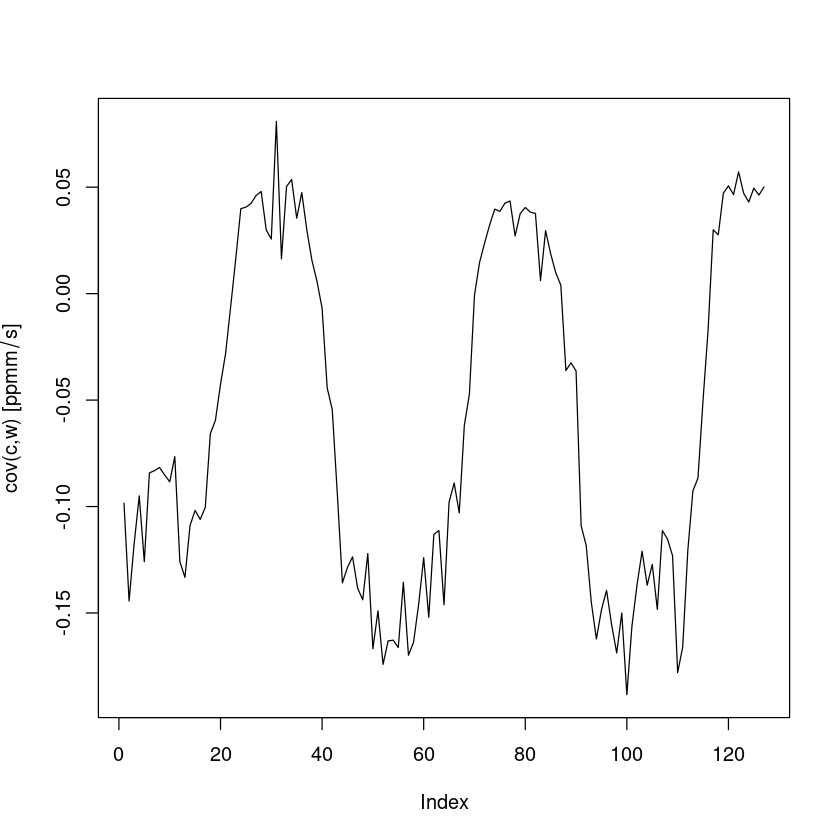

In [25]:
#basic timeseries plots
plot(dat$T_mean,type="l",ylab="temperature [°C]",col=2)
plot(dat$ws_mean,type="l",ylab="wind speed [m/s]")
plot(dat$tke,type="l",ylab=TeX("TKE [$m^2/s^2$]"),ylim=c(0,2))
plot(dat$zeta,type="l",ylab="stability parameter [-]")
abline(h=0,lty=2)
plot(dat$ti,type="l",ylab="turbulence intensity [-]",ylim=c(0,1))
points(dat$iw,type="l",col="gray50")
plot(dat$cov_uw,type="l",ylab=TeX("cov(u,w) [$m^2/s^2$]"))
plot(dat$cov_wT,type="l",ylab=TeX("cov(T,w) [$K m/s$]"))
plot(dat$cov_qw,type="l",ylab=TeX("cov(q,w) [$ppt m/s$]"))
plot(dat$cov_co2w,type="l",ylab=TeX("cov(c,w) [$ppm m/s$]"))

### Regime plots
To diagnose different turbulence regimes, scatter plots of different turbulence diagnostics can be used. Here are some examples plotting wind speed vs TKE or stability parameter vs TKE (see e.g., Sun et al., 2012).

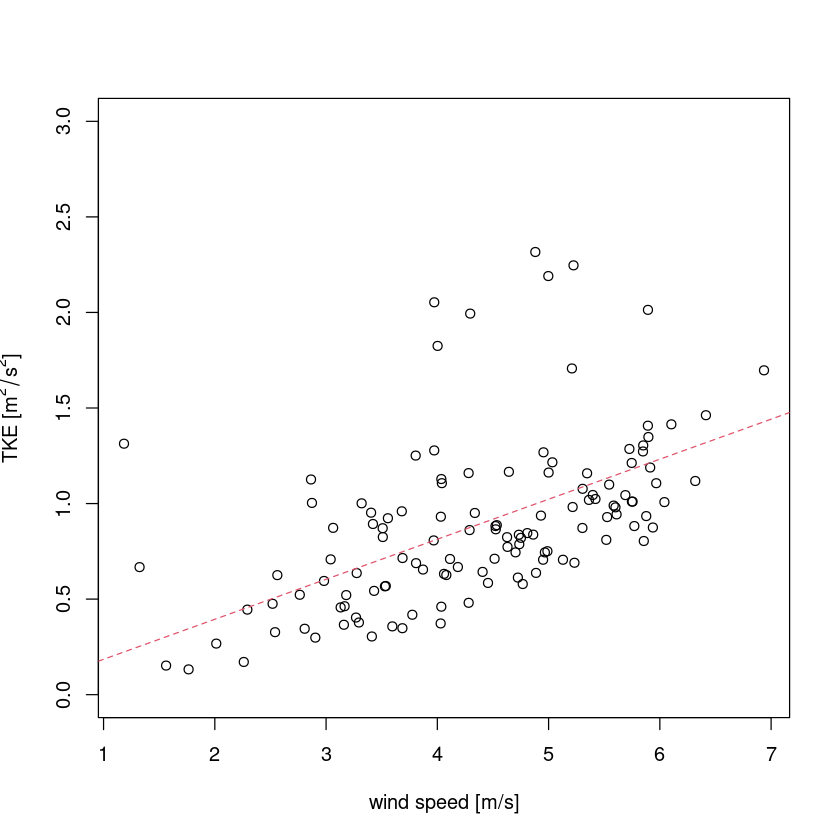

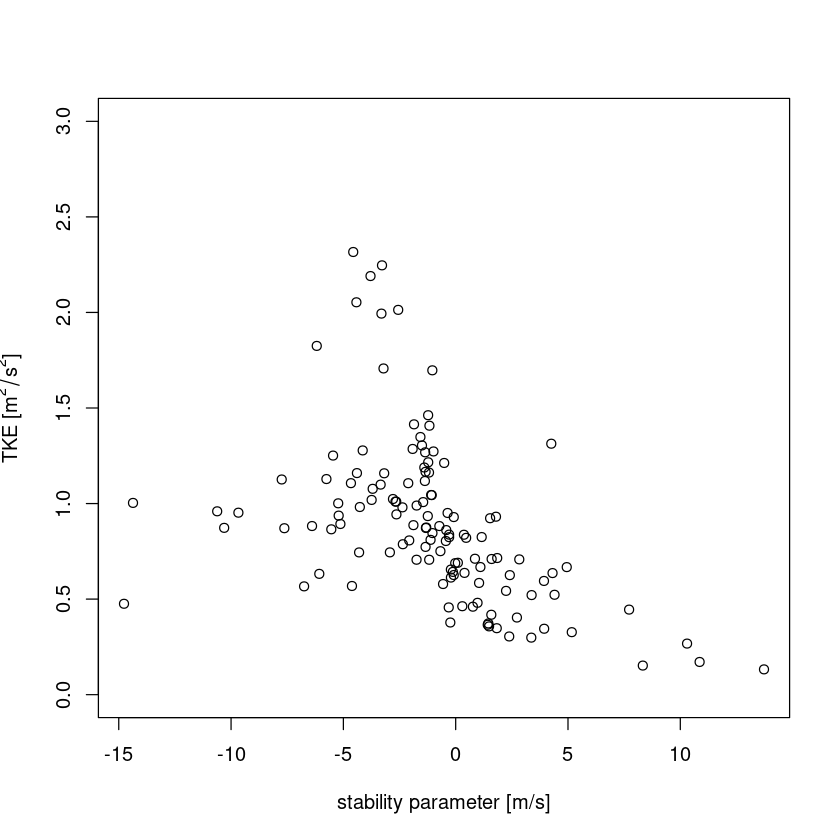

In [27]:
#some basic plots
plot(dat$ws_mean,dat$tke,ylim=c(0,3),xlab="wind speed [m/s]",ylab=TeX("TKE [$m^2/s^2$]"))
cond=(dat$ws_mean>2)
fit=lm(dat$tke[cond]~dat$ws_mean[cond])
abline(fit,col=2,lty=2)

plot(dat$zeta,dat$tke,ylim=c(0,3),xlab="stability parameter [m/s]",ylab=TeX("TKE [$m^2/s^2$]"))

### Literature
- Sun, J., Mahrt, L., Banta, R. M., and Pichugina, Y. L. (2012). Turbulence Regimes and Turbulence Intermittency in the Stable Boundary Layer during CASES-99. J Atmos Sci, 69:338–351.